In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
print(X_motion_CoM_acceleration.shape)
print(Y_motion_CoM_acceleration.shape)

(18641, 21)
(18641, 3)


# Multivariate Linear Regression (CoM Prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
idx_fr_rl_swinging = np.where(X_motion_CoM_acceleration[:, -1] == 1)[0]
X_motion_CoM_acceleration_FR_RL = X_motion_CoM_acceleration[idx_fr_rl_swinging]
Y_motion_CoM_acceleration_FR_RL = Y_motion_CoM_acceleration[idx_fr_rl_swinging]
print(X_motion_CoM_acceleration_FR_RL.shape)
print(Y_motion_CoM_acceleration_FR_RL.shape)

(9317, 21)
(9317, 3)


## Predict CoM (x) movement

In [8]:
X_motion_CoM_acceleration_FR_RL[0, :]

array([0.1, 0.0, 0.0, 0.0292582511902, 0.0129020931199, 0.014509100467,
       0.017187340185, 0.246761634946, 0.131449013948, -0.382426083088,
       0.232240378857, -0.128213062882, -0.386098921299, -0.26756632328,
       0.124969050288, -0.390025764704, -0.253191649914, -0.125525891781,
       -0.386980473995, False, True], dtype=object)

In [9]:
Y_motion_CoM_acceleration_FR_RL[0, :]

array([0.018707819838247906, -0.0007902474427056756,
       -0.000952828930069316], dtype=object)

### Linear Regression

In [10]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [11]:
X_motion_CoM_acceleration_FR_RL[0, :]

array([0.1, 0.0, 0.0, 0.0292582511902, 0.0129020931199, 0.014509100467,
       0.017187340185, 0.246761634946, 0.131449013948, -0.382426083088,
       0.232240378857, -0.128213062882, -0.386098921299, -0.26756632328,
       0.124969050288, -0.390025764704, -0.253191649914, -0.125525891781,
       -0.386980473995, False, True], dtype=object)

In [12]:
# Input
X = np.hstack((X_motion_CoM_acceleration_FR_RL[:, 0:1], # current reference velocity
               X_motion_CoM_acceleration_FR_RL[:, 3:4], # actual velocity
               X_motion_CoM_acceleration_FR_RL[:, 7:9], # FL position
               X_motion_CoM_acceleration_FR_RL[:, 10:12], # FR position
               X_motion_CoM_acceleration_FR_RL[:, 13:15], # RL position
               X_motion_CoM_acceleration_FR_RL[:, 16:18])) # RR position

# Labels
Y = np.array([Y_motion_CoM_acceleration_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_com_x = find_best_model(X, Y, runs=5000)

R2:  0.9858771884499075
RMSE:  0.012518529577978348
The lowest error is:  3.0121475752394977e-05
The highest error is:  0.0481464290535894
The avg. error is:  0.00922921734828433


In [13]:
model_fr_com_x.coef_

array([[ 0.04422648,  0.36155565, -0.11439759, -0.21091345, -0.46140704,
         0.48245202,  0.38302874, -0.1803193 , -0.71142217, -0.62789302]])

In [14]:
model_fr_com_x.intercept_

array([0.08529418])

Text(0, 0.5, 'Predictions')

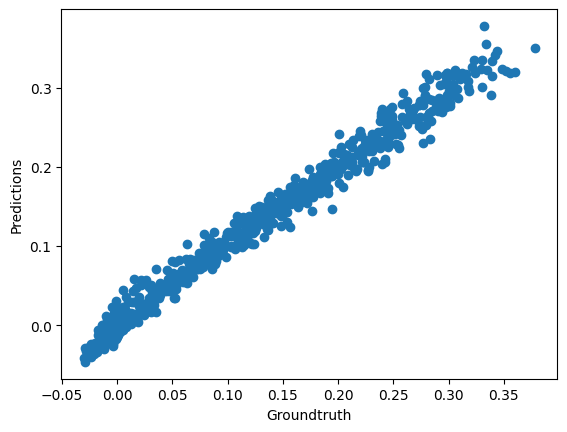

In [15]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [16]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

## Predict CoM -> y

### Linear Regression

In [17]:
# Input
X = np.hstack((X_motion_CoM_acceleration_FR_RL[:, 0:1], # current reference velocity
               X_motion_CoM_acceleration_FR_RL[:, 3:4], # actual velocity
               X_motion_CoM_acceleration_FR_RL[:, 7:9], # FL position
               X_motion_CoM_acceleration_FR_RL[:, 10:12], # FR position
               X_motion_CoM_acceleration_FR_RL[:, 13:15], # RL position
               X_motion_CoM_acceleration_FR_RL[:, 16:18])) # RR position

# Labels
Y = np.array([Y_motion_CoM_acceleration_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_com_y = find_best_model(X, Y, runs=5000)

R2:  0.7298853602831894
RMSE:  0.003339387785293371
The lowest error is:  6.945816225861594e-06
The highest error is:  0.012336850324577375
The avg. error is:  0.002522971264450533


In [18]:
model_fr_com_y.coef_

array([[ 0.00779179, -0.04878178, -0.01757122,  0.05513316, -0.15511127,
        -0.4163938 ,  0.09376421, -0.3365921 ,  0.29582221,  0.30262735]])

In [19]:
model_fr_com_y.intercept_

array([0.16242028])

Text(0, 0.5, 'Predictions')

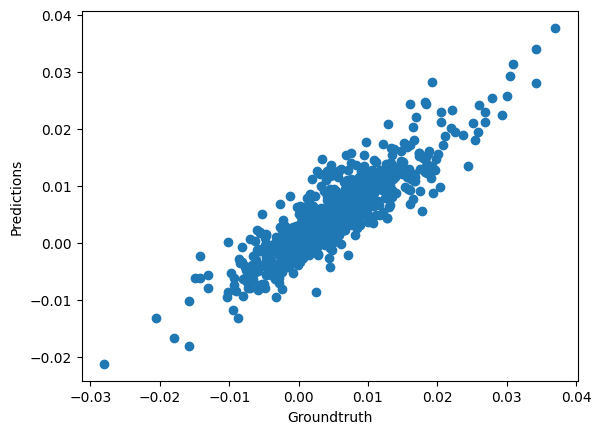

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [21]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')